# SPARK SQL (CLOUDS Fall 2018)

In this notebook, we will learn how to use the DataFrame API and SparkSQL to perform simple data analytics tasks.

# Goals
The main goals of this notebook are the following:
1. Understand the advantages and disadvantages of using DataFrame over RDD
2. Analyze the airline data with the DataFrame API and SparkSQL

# Steps

- First, in section 1, we will go through a short introduction about the DataFrame API with a small example to see how can we use it and how it compares to the low-level RDD abstraction.
- In section 2, we delve into the details of the use case of this notebook including: providing the context, introducing the data
- In section 3, we perform data exploration and analysis

# 1. RDD and DataFrame APIs

In our previous notebooks, we have worked with RDDs (Resilient Distributed Dataset), the basic abstraction in Spark. The main reason is due to the task at hand: we have been invovled in the design of distributed algorithms.

In this laboratory session, we study (or revisit) the DataFrame API - an immutable distributed collection of data.
DataFrames allow developers to impose a **structure** on a distributed collection of data, allowing higher-level abstraction; in addition, DataFrames provide a domain specific language (DSL) API to manipulate distributed, structured data. Ultimately, the goal is to make Spark accessible to a wider audience, beyond researchers and specialized data engineers.

Let's take a small example to see the difference between RDDs and DataFrames. The two cells below contain short code snippets that perform the same task: count the frequency of words in a document, then sort the result in descending order. The first snippet is the same you have been working on in the very [first notebook](https://github.com/EURECOM-CLOUDS-COURSE/Introduction/blob/master/introduction-lab.ipynb) of the CLOUDS course.
The second code snippet uses the DataFrame API.

<div class="alert alert-block alert-info">

<strong>Question 1.</strong> 

Run both approaches (RDD and DataFrame) detailed below, compare their runtime, and discuss. Is the DataFrame API approach faster? Can you explain why?

</div>

In [1]:
import time
time_start = time.time()
words = (
            # read the text file
            sc.textFile("/datasets/gutenberg/gutenberg_small.txt").repartition(16)
            
            # construct words from lines
            .flatMap(lambda line: line.split())
            
            # map each word to (word, 1)
            .map(lambda x: (x, 1))
    
            # reduce by key: accumulate sum the freq of the same word
            .reduceByKey(lambda freq1, freq2: freq1 + freq2)
            
            # swap (word, freq) to (freq, word)
            .map(lambda x: (x[1], x[0]))
    
            # sort result by key DESC
            .sortByKey(False)
         )
print("Runtime: %.2f sec" % (time.time() - time_start))
print(words.take(5))

Runtime: 171.14 sec
[(29556020, 'the'), (18043957, 'of'), (14914748, 'and'), (12892052, 'to'), (9779124, 'a')]


In [2]:
from pyspark.sql.types import *
from pyspark.sql import SQLContext
from pyspark.sql.functions import explode, split, desc
sqlContext = SQLContext(sc)
time_start = time.time()

# read the text file
df = sqlContext.read.text("/datasets/gutenberg/gutenberg_small.txt")

# show 3 samples
# df.show(3)

result = (
    # split into words
    df.select(explode(split(df.value, "\s+|\t+")).alias('word'))
    
    # group by each word
    .groupBy(['word'])
    
    # count the freq
    .count()
    
    # sort the result
    .orderBy(desc("count"))
)

result.show(5)
print("Runtime: %.2f sec" % (time.time() - time_start))

+----+--------+
|word|   count|
+----+--------+
| the|29556020|
|  of|18043957|
|    |16611988|
| and|14914748|
|  to|12892052|
+----+--------+
only showing top 5 rows

Runtime: 114.26 sec


# 2. Analysis of flight data using the DataFrame API and SparkSQL

## Use case

In this notebook, we play the role of a data scientist working in the travel industry, specifically on air transportation of passengers. We want to explore the data collected by the Department of Transportation (DoT) to understand passengers' behavior, as well as the properties of all flights, across several airline companies.

The dataset provided by the DoT has 29 features, that can be either categorical or numerical. For example, the ```src_airport``` (source airport) is categorical: there exist no comparison operator between airport names. We can not say "SGN is bigger than NCE". The ```departure_time``` feature is numerical, for which a comparison operator exists. For instance, "flight departing before 6PM" can be express by "departure_time < 1800".

In this use case, most features are numerical, except carrier, flight_number, cancelled, cancelation_code and diverted. 
The data contains a header, that is useless when analyzing the data: it serves the purpose of an "embedded schema", to help data scientist figure out what information is available. Note that there are some features with missing values in some lines of the dataset. The missing values are marked by "NA". These values can cause problems when processing the data and can lead to unexpected results. Therefore, we need to remove the header and replace all "NA" values by empty values, such as they can be interpreted as null values.

## DataFrame
As we have seen already, there are multiple ways to manipulate data:

- Using the RDD abstraction

- Using the DataFrame abstraction. 

A DataFrame is a distributed collection of data organized into named columns. It is based on the data frame concept in R language or in Pandas for Python. In some sense, it is similar to a table in a relational database: each item is a list of values (the columns). Also, the value in each row of each column can be accessed by the column's name.

To use DataFrames, the data should be clean (no invalid values). That means we cannot create DataFrame directly from the "RAW" data. Instead, we will first create an RDD from RAW data, produce a new, clean RDD, then transform it to a DataFrame and work on it. The RDD `cleaned_data` is an `RDD[String]`. We need to transform it to `RDD[(TypeOfColumn1, TypeOfColumn2, ..., TypeOfColumn29)]` then call a function to create a DataFrame from the new RDD. Please note that, package `com.databricks.spark.csv` can really help us to load the data efficiently without concerns about parsing, conversions, etc... However, the CSV package can have some problems when loading not well-formatted data or the data that has many kinds of missing values. The guidelines defined this notebook are a general way to help you work with any data.


DataFrames can be constructed from a wide array of sources such as: structured data files, tables in Hive, external databases, or existing RDDs.

During the labs in this course, we will mainly work with CSV data files. So, in the next sections, we only focus on constructing dataframes from structured data files directly and from existing RDD.

### Constructing a DataFrame directly from structured data file

To construct DataFrame from a structured file directly, the file type must be supported. Currently, Spark supports csv, json, avro and many more. Among these types, the csv type is one of the most popular in data analytics. A DataFrame is constructed from csv files by using the package spark-csv from Databricks.


In [3]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *

sqlContext = SQLContext(sc)

df = sqlContext.read.load('/datasets/airline/1994.csv', 
    format='com.databricks.spark.csv', 
    header='true', 
    inferSchema='true',
    nullValue='NA'
)

Using the function load parametrized with `com.databricks.spark.csv`, we ask the SqlContext to use the parser from the DataBricks package. Additionally, we can specify whether the file has a header, or ask the parser to guess the data type of columns automatically. The parsed data types is viewed using the function printSchema.

In [4]:
# print(df.dtypes)
df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |

As you can see, the automatically inferred data types are **not** as expected. For example, we expect that `CRSDepTime` to be of interger type. The type and the name of each column can be modified using function ```withColumn``` and ```withColumnRename``` respectively. Additionally, we can also compute and print basic descriptive statistics of numerical columns via the function ```describe``` (similar to Pandas).

In [5]:
df = (df
          # change type of column CRSDepTime by casting its values to interger type
          .withColumn('CRSDepTime', df.CRSDepTime.cast('int'))

          # rename the column
          .withColumnRenamed('CRSDepTime', 'scheduled_departure_time')
    )

# print schema of the current data
df.printSchema()

# run jobs to calculate basic statistic information and show it
df.describe().show()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nulla

### Constructing a DataFrame from an existing RDD

Another way to construct a DataFrame is using data from an existing RDD. The main advantage of this approach is that it does not need a third party library. However, with this method, we have to remove the header ourself and provide a clear schema.



In [1]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import explode, split, desc, col, udf, round
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
import seaborn as sns

sqlContext = SQLContext(sc)

data = sc.textFile('/datasets/airline/1994.csv')

# extract the header
header = data.first()

# replace invalid data with NULL and remove header
cleaned_data = (
        data
    
        # filter out the header
        .filter(lambda line: line != header)
    
         # replace the 'missing data' by empty value
        .map(lambda line: ','.join(list(map(lambda x: x if x != 'NA' else '',line.split(',')))))
    )

airline_data_schema = StructType([ \
    #StructField( name, dataType, nullable)
    StructField("year",                     IntegerType(), True), \
    StructField("month",                    IntegerType(), True), \
    StructField("day_of_month",             IntegerType(), True), \
    StructField("day_of_week",              IntegerType(), True), \
    StructField("departure_time",           IntegerType(), True), \
    StructField("scheduled_departure_time", IntegerType(), True), \
    StructField("arrival_time",             IntegerType(), True), \
    StructField("scheduled_arrival_time",   IntegerType(), True), \
    StructField("carrier",                  StringType(),  True), \
    StructField("flight_number",            StringType(),  True), \
    StructField("tail_number",              StringType(),  True), \
    StructField("actual_elapsed_time",      IntegerType(), True), \
    StructField("scheduled_elapsed_time",   IntegerType(), True), \
    StructField("air_time",                 IntegerType(), True), \
    StructField("arrival_delay",            IntegerType(), True), \
    StructField("departure_delay",          IntegerType(), True), \
    StructField("src_airport",              StringType(),  True), \
    StructField("dest_airport",             StringType(),  True), \
    StructField("distance",                 IntegerType(), True), \
    StructField("taxi_in_time",             IntegerType(), True), \
    StructField("taxi_out_time",            IntegerType(), True), \
    StructField("cancelled",                StringType(),  True), \
    StructField("cancellation_code",        StringType(),  True), \
    StructField("diverted",                 StringType(),  True), \
    StructField("carrier_delay",            IntegerType(), True), \
    StructField("weather_delay",            IntegerType(), True), \
    StructField("nas_delay",                IntegerType(), True), \
    StructField("security_delay",           IntegerType(), True), \
    StructField("late_aircraft_delay",      IntegerType(), True)\
])

In [2]:
# convert each line into a tuple of features (columns) with the corresponding data type
cleaned_data_to_columns = (
    cleaned_data.map(lambda l: l.split(","))
    .map(lambda cols: 
         (
            int(cols[0])  if cols[ 0] else None,
            int(cols[1])  if cols[ 1] else None,
            int(cols[2])  if cols[ 2] else None,
            int(cols[3])  if cols[ 3] else None,
            int(cols[4])  if cols[ 4] else None,
            int(cols[5])  if cols[ 5] else None,
            int(cols[6])  if cols[ 6] else None,
            int(cols[7])  if cols[ 7] else None,
            cols[8]       if cols[ 8] else None,
            cols[9]       if cols[ 9] else None,
            cols[10]      if cols[10] else None,
            int(cols[11]) if cols[11] else None,
            int(cols[12]) if cols[12] else None,
            int(cols[13]) if cols[13] else None,
            int(cols[14]) if cols[14] else None,
            int(cols[15]) if cols[15] else None,
            cols[16]      if cols[16] else None,
            cols[17]      if cols[17] else None,
            int(cols[18]) if cols[18] else None,
            int(cols[19]) if cols[19] else None,
            int(cols[20]) if cols[20] else None,
            cols[21]      if cols[21] else None,
            cols[22]      if cols[22] else None,
            cols[23]      if cols[23] else None,
            int(cols[24]) if cols[24] else None,
            int(cols[25]) if cols[25] else None,
            int(cols[26]) if cols[26] else None,
            int(cols[27]) if cols[27] else None,
            int(cols[28]) if cols[28] else None
         ))             
)
    
# create dataframe
df = sqlContext.createDataFrame(cleaned_data_to_columns, airline_data_schema)\
    .select(['year', 'month', 'day_of_month', 'day_of_week',
            'scheduled_departure_time','scheduled_arrival_time',
            'arrival_delay', 'distance', 
            'src_airport', 'dest_airport', 'carrier'])\
    .cache()

### Examples

Using the contructed DataFrame, we can answer some simple questions:

<ul>
<li>How many night flights do we have in our data?</li>
<li>How many night flights per unique carrier?</li>
</ul>

<strong>NOTE:</strong> We define "night" to start at 6pm.

In [8]:
df[df.scheduled_departure_time > 1800].count()

1078203

In [9]:
df[df.scheduled_departure_time > 1800].groupBy(df.carrier).count().orderBy('count', ascending=0).collect()

[Row(carrier='DL', count=208224),
 Row(carrier='US', count=170397),
 Row(carrier='AA', count=142832),
 Row(carrier='WN', count=124024),
 Row(carrier='UA', count=113640),
 Row(carrier='NW', count=100453),
 Row(carrier='CO', count=94501),
 Row(carrier='TW', count=54771),
 Row(carrier='HP', count=44351),
 Row(carrier='AS', count=25010)]

# 3. Data exploration
Next, we will go over a series of simple queries on our data, to perform exploration and compute statistics using the DataFrame API and SparkSQL. These queries directly map to the questions you need to answer. 

**NOTE:** finding the right question to ask is difficult! Don't be afraid to complement the questions below, with your own questions that, in your opinion, are valuable ways to inspect data. This can give you extra points!

- Basic queries:
  - How many unique origin airports?
  - How many unique destination airports?
  - How many carriers?
  - How many flights that have a scheduled departure time later than 18h00?


- Statistics on flight volume: this kind of statistics are helpful to reason about delays. Indeed, it is plausible to assume that "*the more flights in an airport, the higher the probability of delay*".
  - How many flights in each month of the year?
  - Is there any relationship between the number of flights and the days of week?
  - How many flights in different days of months and in different hours of days?
  - Which are the top 20 busiest airports (this depends on inbound and outbound traffic)?
  - Which are the top 20 busiest carriers?


- Statistics on the fraction of delayed flights
  - What is the percentage of delayed flights (over total flights) for different hours of the day?
  - Which hours of the day are characterized by the longest flight delay?
  - What are the fluctuation of the percentage of delayed flights over different time granularities?
  - What is the percentage of delayed flights which depart from one of the top 20 busiest airports?
  - What is the percentage of delayed flights which belong to one of the top 20 busiest carriers?

## Question 2: Basic queries

### Question 2.1
<div class="alert alert-info">

How many origin airports? How many destination airports? Discuss the results, indicating any discrepancies or strange facts about the data.

</div>

In [3]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- scheduled_arrival_time: integer (nullable = true)
 |-- arrival_delay: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- src_airport: string (nullable = true)
 |-- dest_airport: string (nullable = true)
 |-- carrier: string (nullable = true)



In [4]:
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import col

df.select(countDistinct("src_airport")).show()

df.select(countDistinct("dest_airport")).show()


+---------------------------+
|count(DISTINCT src_airport)|
+---------------------------+
|                        224|
+---------------------------+

+----------------------------+
|count(DISTINCT dest_airport)|
+----------------------------+
|                         225|
+----------------------------+



In [64]:
src_air = (
            df.select('src_airport')
            
            )

dst_air = (
            df.select('dest_airport')
                        )

src_air.subtract(dst_air).show()

dst_air.subtract(src_air).show()

+-----------+
|src_airport|
+-----------+
|        SPN|
+-----------+

+------------+
|dest_airport|
+------------+
|         BFI|
|         GUM|
+------------+



So at the end we have the following results

| count(SRC) | count(DST) | Airoport NOT in DST | Airoport NOT in SRC
|------------|------------|---------------------|--------------------
| 224| 225| SPN | BFI, GUM

> No arrivals to SPN <br>
> No departure from BFI and GUM

### Question 2.2

<div class="alert alert-info">
How many unique carriers are present in the data?
</div>

In [5]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- scheduled_arrival_time: integer (nullable = true)
 |-- arrival_delay: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- src_airport: string (nullable = true)
 |-- dest_airport: string (nullable = true)
 |-- carrier: string (nullable = true)



In [6]:
df.select('carrier').distinct().show()

df.select(countDistinct("carrier")).show()

+-------+
|carrier|
+-------+
|     UA|
|     AA|
|     NW|
|     HP|
|     TW|
|     DL|
|     US|
|     AS|
|     CO|
|     WN|
+-------+

+-----------------------+
|count(DISTINCT carrier)|
+-----------------------+
|                     10|
+-----------------------+



### Question 2.3

<div class="alert alert-info">
DA CAMBIARE
</div>

In [79]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- scheduled_arrival_time: integer (nullable = true)
 |-- arrival_delay: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- src_airport: string (nullable = true)
 |-- dest_airport: string (nullable = true)
 |-- carrier: string (nullable = true)



In [80]:
mask1 = df.scheduled_departure_time > 1800
mask2 = df.scheduled_departure_time < 600

df[mask1 | mask2].count()

1121918

In [89]:
nightFlights = 1121918

totalFlights = df.count()

print(f'{(nightFlights/totalFlights)*100:.2f}%')


21.66%


## Question 3: Flight volume statistics

### Question 3.1: 

<div class="alert alert-info">
How many flights in each month of the year? Plot the changes over months by a line chart and comment the figure.

<br>
From the result, we can learn the dynamics of flight volume over months. For example, if we only consider flights in 1994 (to start, it's always better to focus on smaller amount of data), we can discuss about which months are most likely to have flights experiencing delays.
</div>


In [90]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- scheduled_arrival_time: integer (nullable = true)
 |-- arrival_delay: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- src_airport: string (nullable = true)
 |-- dest_airport: string (nullable = true)
 |-- carrier: string (nullable = true)



In [7]:
df.select('year').distinct().show()

+----+
|year|
+----+
|1994|
+----+



In [101]:
import pandas as pd
pandasDF = df.groupBy('year','month').count().sort('month').toPandas()

In [102]:
pandasDF

,year,month,count
0,1994,1,423861
1,1994,2,386954
2,1994,3,435516
3,1994,4,420995
4,1994,5,436432
5,1994,6,426490
6,1994,7,443736
7,1994,8,451086
8,1994,9,430861
9,1994,10,449369


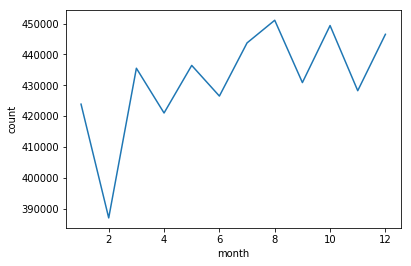

In [103]:
import seaborn as sn


sns.lineplot(data=pandasDF, x="month", y="count")

At the end we have

|index | Month | Count 
|------|-------|-------
|1| Jan   | 423861
|2| Feb   | 386954
|3| Mar   | 435516
|4| Apr   | 420995
|5| May   | 436432
|6| Jun   | 426490
|7| Jul   | 443736
|**8**| **Aug**   | **451086**
|9| Sep   | 430861
|10| Oct   | 449369
|11| Nov   | 428227
|12| Dec   | 446521

<br>

We have a **Pick** in **August, October** and **December** <br>
and a **Fall** in **February**
<br>

From the graph it is possible to notice an overall increasing of the num. of flights from Jan to December. 
<br>
The delay caused by the overall amount of flights is expected mostly in the last part of the year (with a big consideration of August). The other way around for the beginning of the year. 


### Question 3.2: 

<div class="alert alert-info">
Is there any relationship between the number of flights and the days of the week?  

Plot a bar chart and interpret the figure.

<br>
<br>
<strong>NOTE:</strong> You should study both global aggregates (irrespectively of the month of the year), and monthly aggregates (day statistics, for each different month of the year).

<br>
<br>
By answering this question, we could learn about the importance of the weekend/weekday feature for our predictive task.
</div>

In [71]:
def plot_fun(var1, var2, subTitle, title1, title2, orient = 'v'):
    
    df1, x1, y1 = var1    
    df2, x2, y2, hue = var2

    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,15))

    fig.suptitle(subTitle)

    sns.color_palette("rocket_r")

    ax1.grid(True)
    ax1.set_title(title1)
    
    sns.barplot(x=df1[x1], 
                y=df1[y1],
                ax = ax1, 
                palette = 'Blues')

    ax2.grid(True)
    ax2.set_title(title2)
    g = sns.barplot(x=df2[x2],
                y=df2[y2],
                hue=df2[hue],
                ax = ax2, 
               palette = 'Blues',
               orient=orient)
    #g.set_yscale("log")
    
    plt.legend(loc='lower right')
    

In [65]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- scheduled_arrival_time: integer (nullable = true)
 |-- arrival_delay: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- src_airport: string (nullable = true)
 |-- dest_airport: string (nullable = true)
 |-- carrier: string (nullable = true)



In [10]:
month_week_count = df.groupBy('month','day_of_week').count().sort('month','day_of_week').toPandas()
week_count = df.groupBy('day_of_week').count().sort('day_of_week').toPandas()

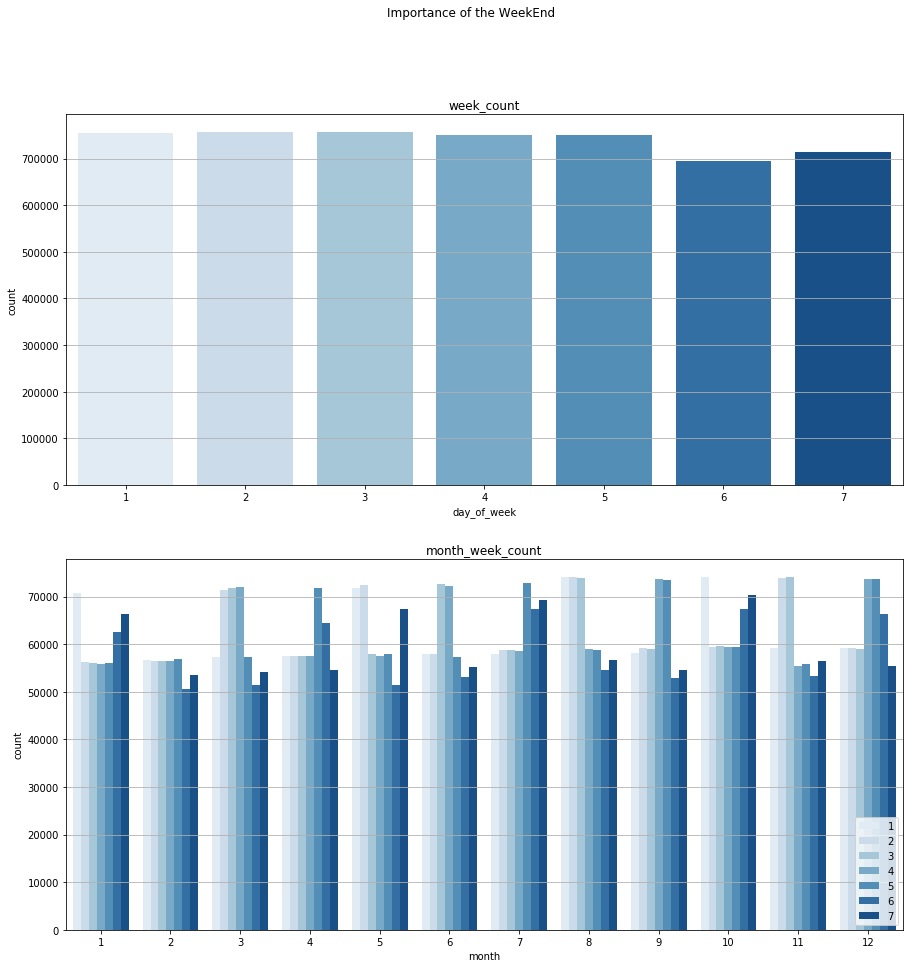

In [74]:
var1 = (week_count, 'day_of_week', 'count')
var2 = (month_week_count, 'month', 'count', 'day_of_week')

plot_fun(var1, var2, 'Importance of the WeekEnd', 'week_count', 'month_week_count')

**First Plot**

From the first plot is possbile to notice that at the beginning of the week we have an overall constant number of flights, arount 75000. This number slightly decrease in the weekend.

**Second Plot**
Much more useful is the second plot where it is possible to througly understand the differences w.r.t the number of flights per days.

| Month | Most Flights | 
|-------|--------------|
| Jan   | Mon-Sun 
| Feb   | equal 
| Mar   | Tue/Thu 
| Apr   | Fri-Sat 
| May   | Sun/Tue 
| Jun   | Wen-Thu 
| Jul   | weekend 
| Aug   | Mon/Wen 
| Sep   | Thu-Fri 
| Oct   | Sat/Mon 
| Nov   | Mon-Wen 
| Dec   | Thu/Sat 

### Question 3.3

<div class="alert alert-info">
How many flights in different days of months and in different hours of days?  
<br>
<br>

<strong>NOTE:</strong> Similarly to the previous note, you need to compute both global statistcs and monthly statistics.

<br>
<br>
Plot  bar charts, and interpret your figures.
</div>

In [13]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- scheduled_arrival_time: integer (nullable = true)
 |-- arrival_delay: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- src_airport: string (nullable = true)
 |-- dest_airport: string (nullable = true)
 |-- carrier: string (nullable = true)



In [14]:
day_month_count = df.groupBy('day_of_month').count().sort('day_of_month').toPandas()
day_month_month_count = df.groupBy('month','day_of_month').count().sort('month','day_of_month').toPandas()

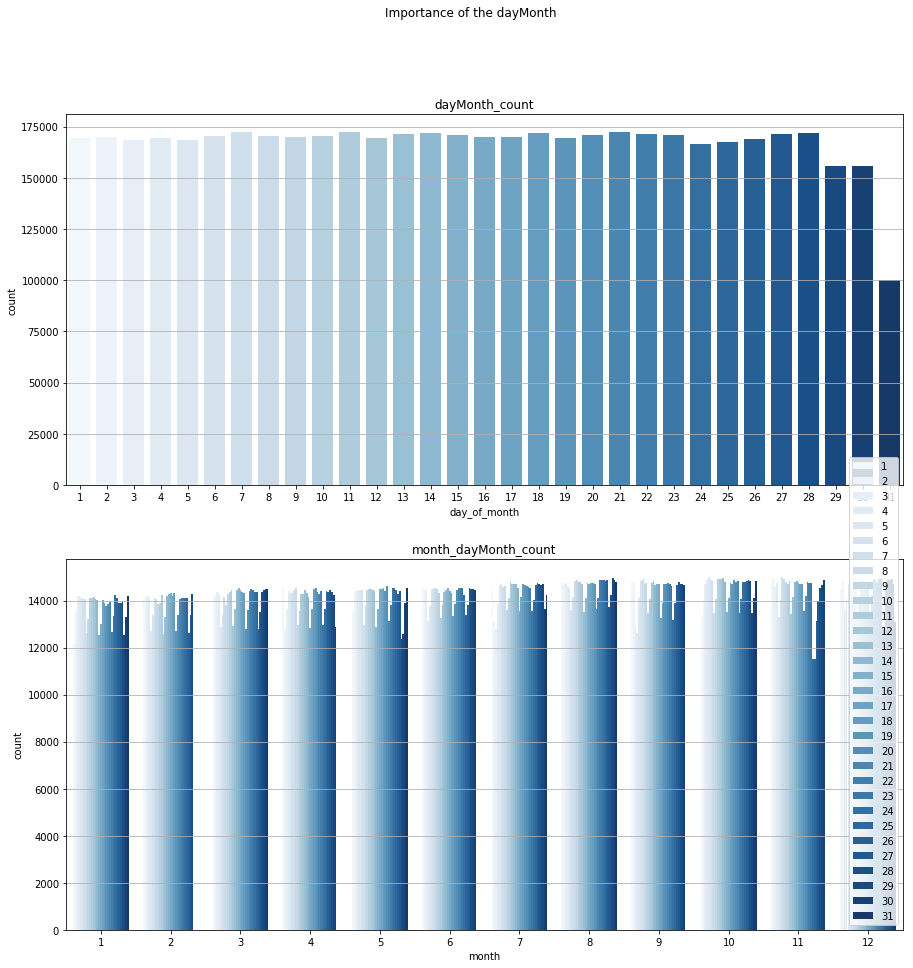

In [28]:
var1 = (day_month_count, 'day_of_month', 'count')
var2 = (day_month_month_count, 'month', 'count', 'day_of_month')

plot_fun(var1, var2, 'Importance of the dayMonth', 'dayMonth_count', 'month_dayMonth_count')

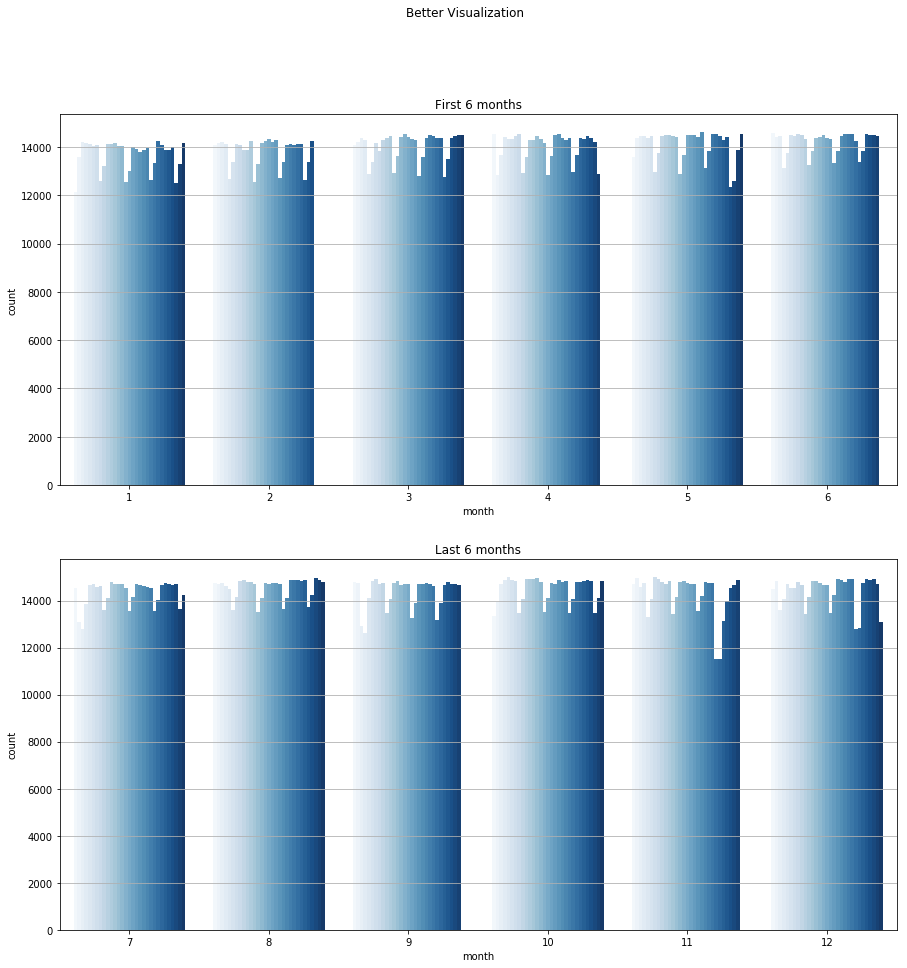

In [109]:
df1 = day_month_month_count[day_month_month_count.month < 7]
df2 = day_month_month_count[day_month_month_count.month >= 7]


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,15))

fig.suptitle('Better Visualization')

#sns.color_palette("rocket_r")

ax1.grid(True)
ax1.set_title('First 6 months')
sns.barplot(x=df1['month'], 
            y=df1['count'],
            hue=df1['day_of_month'],
            ax = ax1, 
            palette = 'Blues')
ax1.get_legend().remove()

ax2.grid(True)
ax2.set_title('Last 6 months')
g = sns.barplot(x=df2['month'],
                y=df2['count'],
                hue=df2['day_of_month'],
                ax = ax2, 
               palette = 'Blues',
               )
ax2.get_legend().remove()

### Question 3.4

<div class="alert alert-info">
Which are the **top 20** busiest airports? Compute this in terms of the inbound, outbound and total number of flights.
</div>

In [110]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- scheduled_arrival_time: integer (nullable = true)
 |-- arrival_delay: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- src_airport: string (nullable = true)
 |-- dest_airport: string (nullable = true)
 |-- carrier: string (nullable = true)



##### Inbounds

In [176]:
inboundsDF = (
            df.groupBy('src_airport')
                .count()
                .sort(col('count').desc())
                .withColumnRenamed('count', 'count_inbound')
            )
inboundsDF.show(20)

+-----------+-------------+
|src_airport|count_inbound|
+-----------+-------------+
|        ORD|       277741|
|        DFW|       256274|
|        ATL|       221486|
|        LAX|       153494|
|        STL|       151609|
|        DEN|       141427|
|        PHX|       139581|
|        DTW|       136837|
|        PIT|       130977|
|        CLT|       129391|
|        MSP|       123222|
|        SFO|       118233|
|        EWR|       116768|
|        IAH|       104182|
|        LGA|       101864|
|        BOS|       100365|
|        LAS|        94972|
|        PHL|        93585|
|        DCA|        88445|
|        MCO|        77120|
+-----------+-------------+
only showing top 20 rows



##### Outbounds

In [177]:
outboundsDF = (
                df.groupBy('dest_airport')
                    .count()
                    .sort(col('count').desc())
                    .withColumnRenamed('count', 'count_outbound')
                )
outboundsDF.show(20)

+------------+--------------+
|dest_airport|count_outbound|
+------------+--------------+
|         ORD|        283720|
|         DFW|        260249|
|         ATL|        221588|
|         LAX|        152959|
|         STL|        152800|
|         DEN|        144099|
|         PHX|        140979|
|         DTW|        139435|
|         PIT|        131962|
|         CLT|        130321|
|         MSP|        124758|
|         SFO|        117245|
|         EWR|        117223|
|         IAH|        104409|
|         LGA|        101498|
|         BOS|         99331|
|         LAS|         94948|
|         PHL|         93312|
|         DCA|         87670|
|         MCO|         76600|
+------------+--------------+
only showing top 20 rows



##### Flights

In [180]:
busiest_airport = (inboundsDF.join(outboundsDF,
                inboundsDF.src_airport == outboundsDF.dest_airport,
                'outer')
          .withColumn('SUM', col('count_inbound') + col('count_outbound'))
          .withColumnRenamed('src_airport', 'airport')
          .select('airport','SUM')
          .sort(col('SUM').desc())
    )

busiest_airport.show(20)
pdf_busiest_airport = busiest_airport.toPandas().iloc[:21][:]

+-------+------+
|airport|   SUM|
+-------+------+
|    ORD|561461|
|    DFW|516523|
|    ATL|443074|
|    LAX|306453|
|    STL|304409|
|    DEN|285526|
|    PHX|280560|
|    DTW|276272|
|    PIT|262939|
|    CLT|259712|
|    MSP|247980|
|    SFO|235478|
|    EWR|233991|
|    IAH|208591|
|    LGA|203362|
|    BOS|199696|
|    LAS|189920|
|    PHL|186897|
|    DCA|176115|
|    MCO|153720|
+-------+------+
only showing top 20 rows



In [181]:
pdf_busiest_airport

,airport,SUM
0,ORD,561461.0
1,DFW,516523.0
2,ATL,443074.0
3,LAX,306453.0
4,STL,304409.0
5,DEN,285526.0
6,PHX,280560.0
7,DTW,276272.0
8,PIT,262939.0
9,CLT,259712.0


### Question 3.5
<div class="alert alert-info">
Which are the **top 20** busiest carriers? Compute this in terms of number of flights.
</div>


In [138]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- scheduled_arrival_time: integer (nullable = true)
 |-- arrival_delay: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- src_airport: string (nullable = true)
 |-- dest_airport: string (nullable = true)
 |-- carrier: string (nullable = true)



In [139]:
df.groupBy('carrier').count().sort(col('count').desc()).show(20)

+-------+------+
|carrier| count|
+-------+------+
|     DL|874526|
|     US|857906|
|     AA|722277|
|     UA|638750|
|     WN|565426|
|     CO|484834|
|     NW|482798|
|     TW|258205|
|     HP|177851|
|     AS|117475|
+-------+------+



## Question 4 
In this series of questions we focus on the computation of statistics about the percentage of delayed flights.

### Question 4.1
<div class="alert alert-info">
What is the percentage of delayed flights for different hours of the day?  

Plot a bar chart and interpret the figure.  


<div class="label label-success">IMPORTANT!</div> A flight is considered as delayed if it's actual arrival time is more than 15 minutes later than the scheduled arrival time.

</div>

In [4]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- scheduled_arrival_time: integer (nullable = true)
 |-- arrival_delay: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- src_airport: string (nullable = true)
 |-- dest_airport: string (nullable = true)
 |-- carrier: string (nullable = true)



In [5]:
from pyspark.sql.session import SparkSession

spark = SparkSession.builder.getOrCreate()

def casting_fun(num):
    """
    this function is used to cast the hours
    """
    
    if 0<=num<99:
        return 0
    if 100<=num<199:
        return 1
    if 200<=num<299:
        return 2
    if 300<=num<399:
        return 3
    if 400<=num<499:
        return 4
    if 500<=num<599:
        return 5
    if 600<=num<699:
        return 6
    if 700<=num<799:
        return 7
    if 800<=num<899:
        return 8    
    if 900<=num<999:
        return 9
    if 1000<=num<1099:
        return 10    
    if 1100<=num<1199:
        return 11
    if 1200<=num<1299:
        return 12
    if 1300<=num<1399:
        return 13
    if 1400<=num<1499:
        return 14
    if 1500<=num<1599:
        return 15
    if 1600<=num<1699:
        return 16
    if 1700<=num<1799:
        return 17
    if 1800<=num<1899:
        return 18    
    if 1900<=num<1999:
        return 19
    if 2000<=num<2099:
        return 20    
    if 2100<=num<2199:
        return 21
    if 2200<=num<2299:
        return 22
    if 2300<=num<2399:
        return 23
    if 2400<=num<2499:
        return 0
    return num
        
spark.udf.register("casting_hours", casting_fun)

In [6]:
def delay_map(delay):
    if delay == None:
        return 0 # I am assuming that the None values are not delay
    if delay > 15:
        return 1
    else: 
        return 0
    
spark.udf.register("delay_map", delay_map)

In [7]:
from pyspark.sql.functions import lit

df_hours = (
            df
                .selectExpr('int(casting_hours(scheduled_arrival_time)) as hours',
                              'int(delay_map(arrival_delay)) as delay_map')
    
                .withColumn('new_col', lit(1))
    
                .groupby('hours').sum('delay_map', 'new_col')
                .withColumnRenamed('sum(delay_map)', 'sum_delay')                
                .withColumnRenamed('sum(new_col)', 'sum_total')
    
                .selectExpr('hours', 'float(sum_total/sum_delay) as percentage')
    
    
                .orderBy('hours')
              )

df_hours.show(25)

+-----+----------+
|hours|percentage|
+-----+----------+
|    0| 5.0980487|
|    1| 5.8141594|
|    2| 4.8857937|
|    3|  4.776722|
|    4|  8.160278|
|    5|  8.546192|
|    6|10.3143015|
|    7| 15.499167|
|    8| 11.936946|
|    9|  9.647533|
|   10| 8.2394085|
|   11| 7.4430866|
|   12|  7.967538|
|   13| 7.9191074|
|   14|  6.942313|
|   15|  6.534554|
|   16| 5.6124644|
|   17|  5.180985|
|   18| 4.8833814|
|   19| 4.8239474|
|   20| 4.4586234|
|   21|  4.585471|
|   22| 5.0009065|
|   23|  4.895432|
+-----+----------+



In [8]:
df_hours.printSchema()

root
 |-- hours: integer (nullable = true)
 |-- percentage: float (nullable = true)



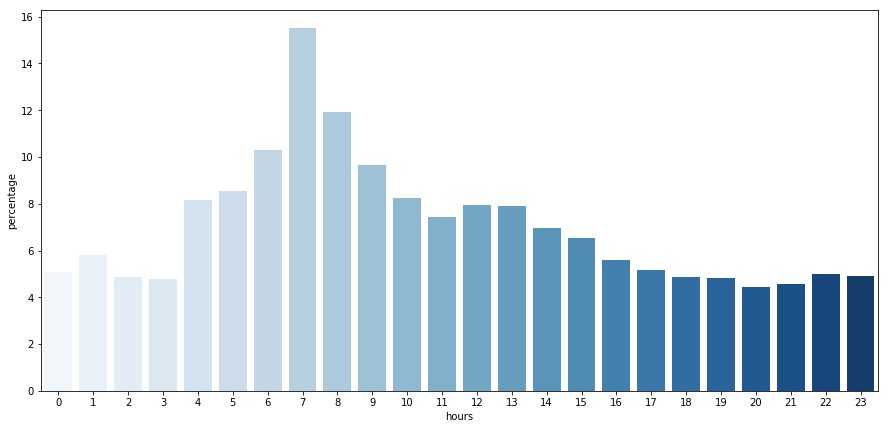

In [145]:
plt.figure(figsize=(15, 7))
sns.barplot(x=df_hours.toPandas()['hours'], 
            y=df_hours.toPandas()['percentage'],
            palette = 'Blues')



### Question 4.2
<div class="alert alert-info">
You will realize that saying *"at 4 A.M. there is a very low chance of a flight being delayed"* is not giving you a full picture of the situation. Indeed, it might be true that there is very little probability for an early flight to be delayed, but if it does, the delay might be huge, like 6 hours!  

<ul></ul>

Then, the question is: **which hours of the day are characterized by the largest mean delay?** (you can consider the median too)  

Plot a Bar chart and explain it.  

</div>

With data of year 1994, the flight from 3AM to 4AM often depart earlier than in their schedule. The flights in the morning have less delay then in the afternoon and evening.

So, an attentive student should notice here that we have somehow a problem with the definition of delay! Next, we will improve how to represent and visualize data to overcome this problem.

**NOTE**: the following piece of code assumes you correctly answered the previous questions. The naming convention of the DataFrames we use next should be clear enough for you to produce them by answering the questions above.

In [18]:
mean_delay_per_hour = (
                        df.selectExpr('int(casting_hours(scheduled_arrival_time)) as hours', 'arrival_delay')
                          .groupby('hours').mean('arrival_delay')
                          .withColumnRenamed('avg(arrival_delay)', "mean_delay")
                          .orderBy('hours')
)

mean_delay_per_hour.show()

+-----+------------------+
|hours|        mean_delay|
+-----+------------------+
|    0|  7.79829048759956|
|    1| 5.318805765271105|
|    2| 9.308157970596714|
|    3|  9.63504016064257|
|    4|2.3952879581151834|
|    5|1.6789442913221415|
|    6|1.0751172406138136|
|    7|0.7533132980989556|
|    8|1.4819354838709677|
|    9| 2.135063484889343|
|   10|2.8256796577804293|
|   11| 3.544646429600696|
|   12|3.2134644700638257|
|   13|3.4402007959357612|
|   14| 4.391326719952099|
|   15| 5.006474409418445|
|   16| 6.661893089548997|
|   17|7.7214029205399655|
|   18| 8.633287301772539|
|   19| 9.060501700436436|
+-----+------------------+
only showing top 20 rows



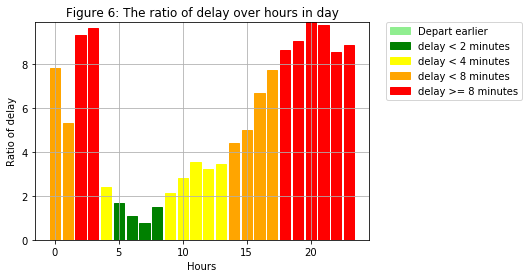

In [54]:
pdf_mean_delay_per_hour = pd.DataFrame(data=mean_delay_per_hour.collect())

plt.xlabel("Hours")
plt.ylabel("Ratio of delay")
plt.title('Figure 6: The ratio of delay over hours in day')
plt.grid(True,which="both",ls="-")

bars = plt.bar(pdf_mean_delay_per_hour[0], pdf_mean_delay_per_hour[1], align='center', edgecolor = "black")

for i in range(0, len(bars)):
    color = 'red'
    if pdf_mean_delay_per_hour[1][i] < 0:
        color = 'lightgreen'
    elif pdf_mean_delay_per_hour[1][i] < 2:
        color = 'green'
    elif pdf_mean_delay_per_hour[1][i] < 4:
        color = 'yellow'
    elif pdf_mean_delay_per_hour[1][i] < 8:
        color = 'orange'

    bars[i].set_color(color)
        
patch1 = mpatches.Patch(color='lightgreen', label='Depart earlier')
patch2 = mpatches.Patch(color='green', label='delay < 2 minutes')
patch3 = mpatches.Patch(color='yellow', label='delay < 4 minutes')
patch4 = mpatches.Patch(color='orange', label='delay < 8 minutes')
patch5 = mpatches.Patch(color='red', label='delay >= 8 minutes')

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.margins(0.05, 0)
plt.show()

In the new figure (Figure 6), we have more information in a single plot. The flights in 3AM to 4AM have very low probability of being delayed, and actually depart earlier than their schedule. In contrast, the flights in the 4PM to 8PM range have higher chances of being delayed: in more than 50% of the cases, the delay is 8 minutes or more.

This example shows us that the way representing results are also important.


### Question 4.3

<div class="alert alert-info">
Plot a bar chart to show the percentage of delayed flights over days in a month. Discuss your findings from the figure.
</div>

In [26]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- scheduled_arrival_time: integer (nullable = true)
 |-- arrival_delay: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- src_airport: string (nullable = true)
 |-- dest_airport: string (nullable = true)
 |-- carrier: string (nullable = true)



In [43]:
def casting_delayed(x):
    if x >= 15:
        return 1
    return 0 

In [150]:
delayed_flight = df.filter(df.arrival_delay.isNotNull())\
                   .selectExpr('year','month', 'day_of_month', 'day_of_week', 'int(casting_delayed(arrival_delay)) as map_delay')\
                   .withColumn('tot', lit(1))\
                   .cache() #used 3 times
delayed_flight.show()

+----+-----+------------+-----------+---------+---+
|year|month|day_of_month|day_of_week|map_delay|tot|
+----+-----+------------+-----------+---------+---+
|1994|    1|           7|          5|        0|  1|
|1994|    1|           8|          6|        0|  1|
|1994|    1|          10|          1|        1|  1|
|1994|    1|          11|          2|        1|  1|
|1994|    1|          12|          3|        1|  1|
|1994|    1|          14|          5|        0|  1|
|1994|    1|          15|          6|        0|  1|
|1994|    1|          17|          1|        0|  1|
|1994|    1|          18|          2|        0|  1|
|1994|    1|          19|          3|        0|  1|
|1994|    1|          20|          4|        0|  1|
|1994|    1|          22|          6|        0|  1|
|1994|    1|          24|          1|        0|  1|
|1994|    1|          25|          2|        0|  1|
|1994|    1|          27|          4|        0|  1|
|1994|    1|          28|          5|        1|  1|
|1994|    1|

In [134]:
spark.udf.register("casting_delayed", casting_delayed)

percent_delay_per_dayMonth = (delayed_flight
                                 .groupby('month', 'day_of_month').sum('map_delay', 'tot')
                                 .withColumnRenamed('sum(map_delay)', 'sum_delay')
                                 .withColumnRenamed('sum(tot)', 'sum_tot')

                                 .selectExpr('month', 'day_of_month', 'double(sum_delay/sum_tot)*100 as percentage')

                                 .orderBy('month', 'day_of_month')
                            )

percent_delay_per_dayMonth.show(31)

+-----+------------+------------------+
|month|day_of_month|        percentage|
+-----+------------+------------------+
|    1|           1|12.232897134338247|
|    1|           2| 25.13535563301936|
|    1|           3| 32.24697371248478|
|    1|           4|  30.2685863433527|
|    1|           5| 33.83351997013811|
|    1|           6| 33.55714824594493|
|    1|           7|26.834037228218367|
|    1|           8|18.138592938275952|
|    1|           9| 19.90964086070909|
|    1|          10| 19.99710501556054|
|    1|          11|20.375836993304052|
|    1|          12| 33.29467254310678|
|    1|          13| 26.09234809249398|
|    1|          14|26.424682395644282|
|    1|          15|13.251355068360166|
|    1|          16|29.165653125760155|
|    1|          17|37.422671429816155|
|    1|          18|31.260780287474333|
|    1|          19|30.941527821439802|
|    1|          20|31.293889137905275|
|    1|          21|20.936999854503128|
|    1|          22|10.209131545338442|


In [135]:
pdf_month_day_percent = pd.DataFrame(data=percent_delay_per_dayMonth.collect())
pdf_month_day_percent.head()

,0,1,2
0,1,1,12.232897
1,1,2,25.135356
2,1,3,32.246974
3,1,4,30.268586
4,1,5,33.833520


In [147]:
def plot_day_over_month(pdf, title, x_title):
    
    plt.figure(figsize=(10,6))
    plt.xlabel(x_title)
    plt.ylabel("percentage delayed fly")
    plt.title(f'The ratio of delay over days in {title}')
    plt.grid(True,which="both")
    
    bars = plt.bar(pdf[1], pdf[2], align='center', edgecolor = "black")

    for i in range(0, len(bars)):
        color = 'red'
        if pdf.iloc[i, 1] < 10:
            color = 'lightgreen'
        elif pdf.iloc[i, 1] < 20:
            color = 'green'
        elif pdf.iloc[i, 1] < 30:
            color = 'yellow'
        elif pdf.iloc[i, 1] < 40:
            color = 'orange'

        bars[i].set_color(color)

    patch1 = mpatches.Patch(color='lightgreen', label='ratio < 10%')
    patch2 = mpatches.Patch(color='green', label='ratio < 20%')
    patch3 = mpatches.Patch(color='yellow', label='ratio < 30%')
    patch4 = mpatches.Patch(color='orange', label='ratio < 40%')
    patch5 = mpatches.Patch(color='red', label='ratio >= 40%')

    plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.margins(0.05, 0)

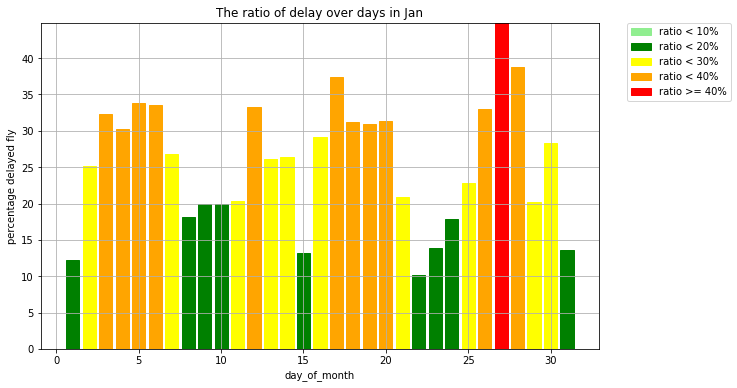

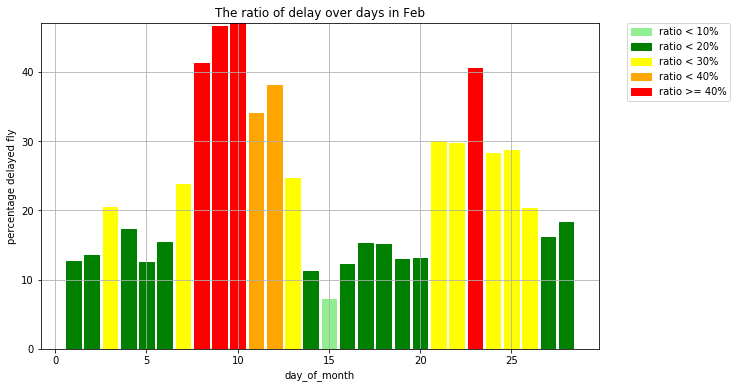

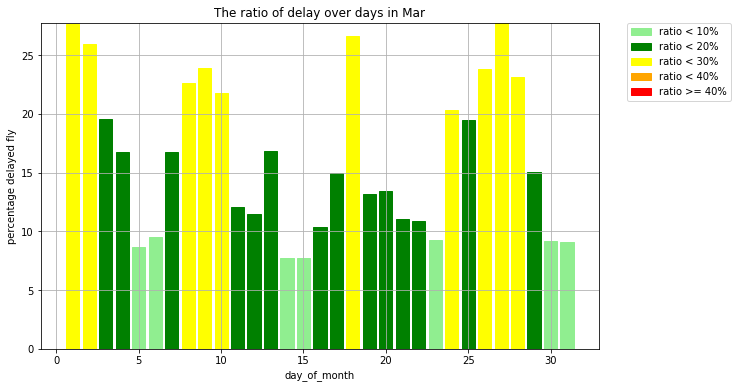

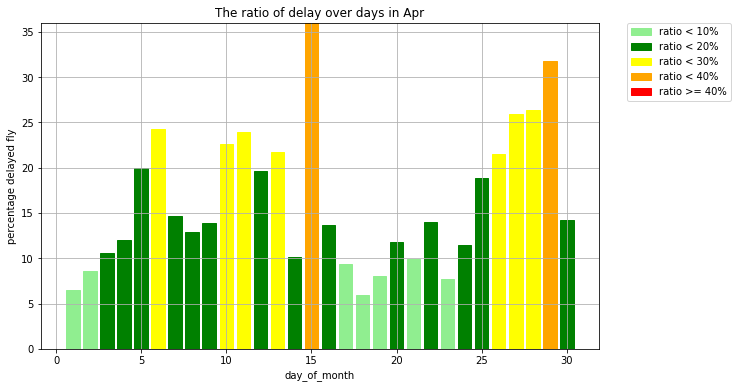

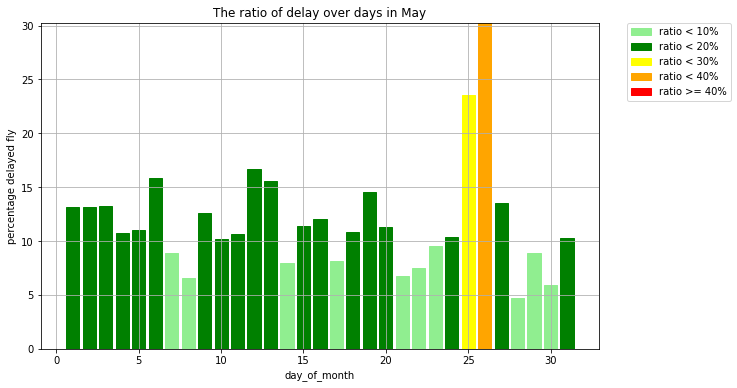

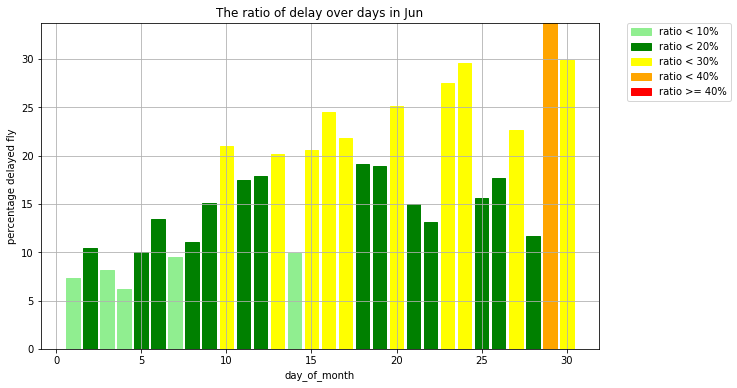

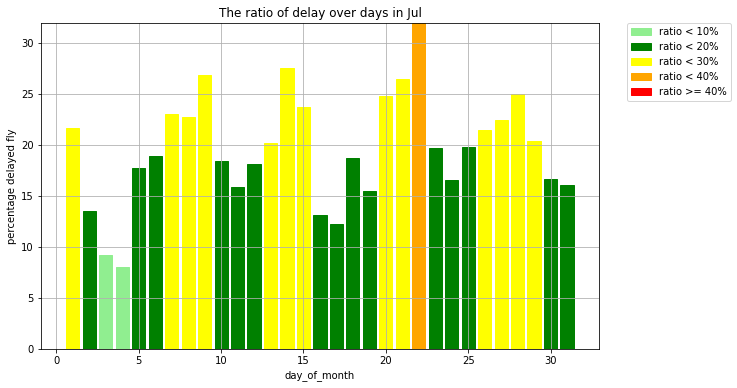

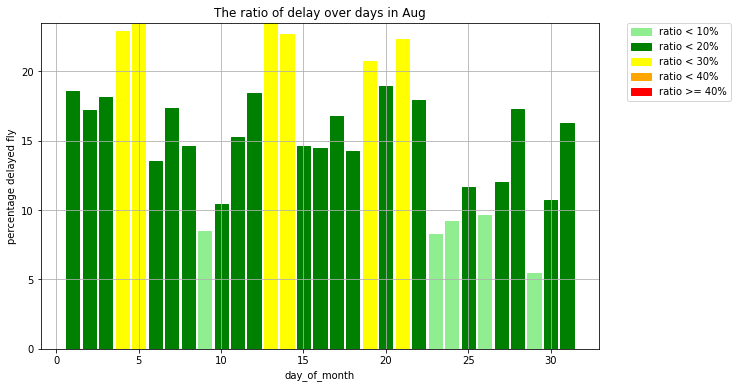

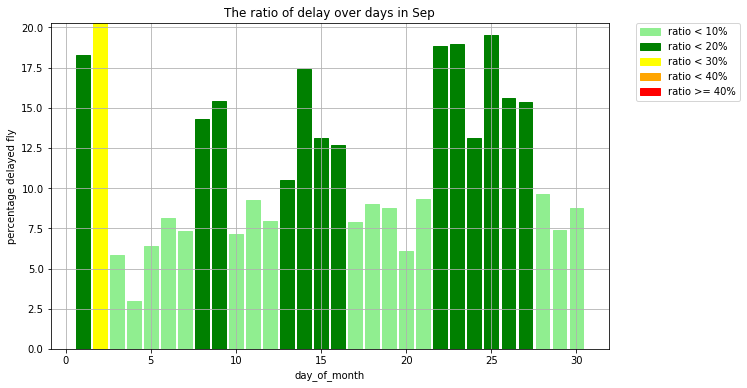

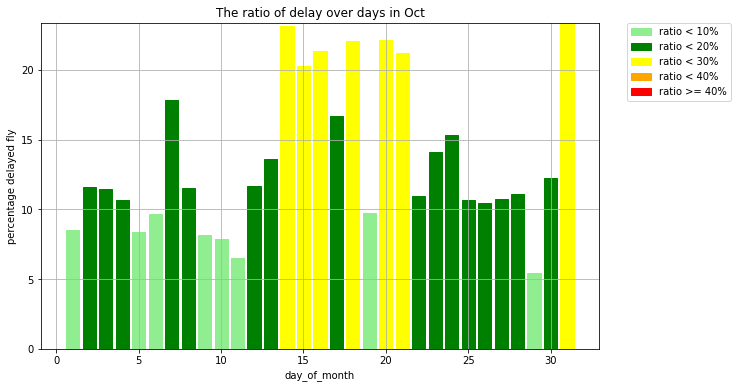

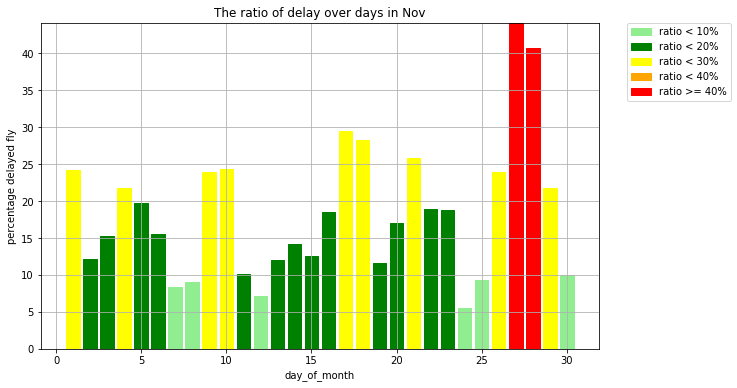

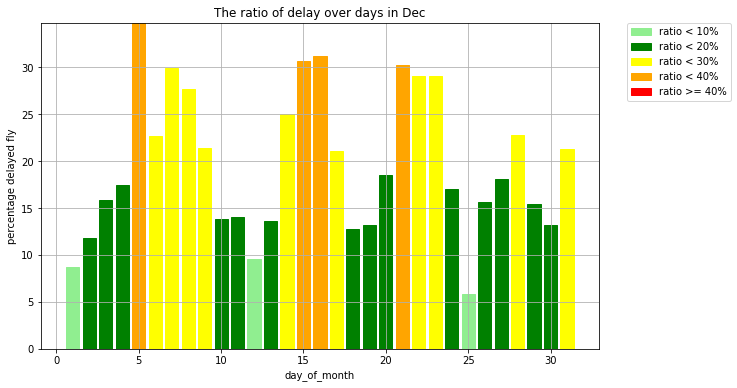

In [148]:
month= ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for i in range(1,13):
    pdf = pdf_month_day_percent[pdf_month_day_percent[0] == i][[1,2]]
    
    plot_day_over_month(pdf, month[i-1], 'day_of_month')
    

### Question 4.4

<div class="alert alert-info">
Plot a bar chart to show the percentage of delayed flights over days in a week. Discuss your findings from the figure.
</div>

In [142]:
percent_delay_per_dayWeek = (delayed_flight
                                 .groupby('month', 'day_of_week').sum('map_delay', 'tot')
                                 .withColumnRenamed('sum(map_delay)', 'sum_delay')
                                 .withColumnRenamed('sum(tot)', 'sum_tot')

                                 .selectExpr('month', 'day_of_week', 'double(sum_delay/sum_tot)*100 as percentage')

                                 .orderBy('month', 'day_of_week')
                            )

percent_delay_per_dayWeek.show(31)

+-----+-----------+------------------+
|month|day_of_week|        percentage|
+-----+-----------+------------------+
|    1|          1|23.745610380334504|
|    1|          2|25.895600762378933|
|    1|          3|  32.7958642426106|
|    1|          4| 33.65380954194113|
|    1|          5| 28.09035216296463|
|    1|          6|14.719498232863756|
|    1|          7|  23.2013557233092|
|    2|          1|20.757229490201723|
|    2|          2|21.521961571986207|
|    2|          3| 26.98633796366967|
|    2|          4| 27.23128951624761|
|    2|          5|22.909676293178688|
|    2|          6|20.618619720031788|
|    2|          7| 17.26744075919156|
|    3|          1|14.643467234911858|
|    3|          2| 16.62655719139298|
|    3|          3|15.508143090818576|
|    3|          4| 17.06802099977174|
|    3|          5| 18.65795222324008|
|    3|          6| 14.24791250147007|
|    3|          7|16.867872664462688|
|    4|          1|15.138939959027159|
|    4|          2| 17.23

In [143]:
pdf_month_week_percent = pd.DataFrame(data = percent_delay_per_dayWeek.collect())
pdf_month_week_percent.head()

,0,1,2
0,1,1,23.745610
1,1,2,25.895601
2,1,3,32.795864
3,1,4,33.653810
4,1,5,28.090352


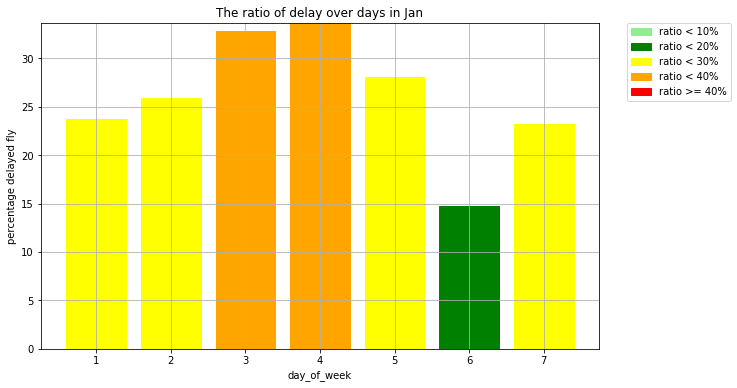

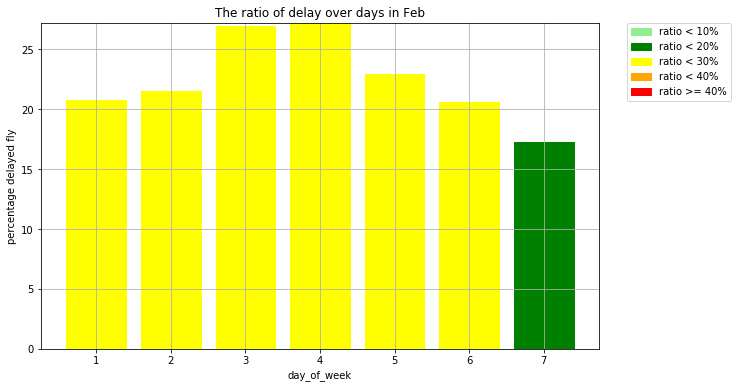

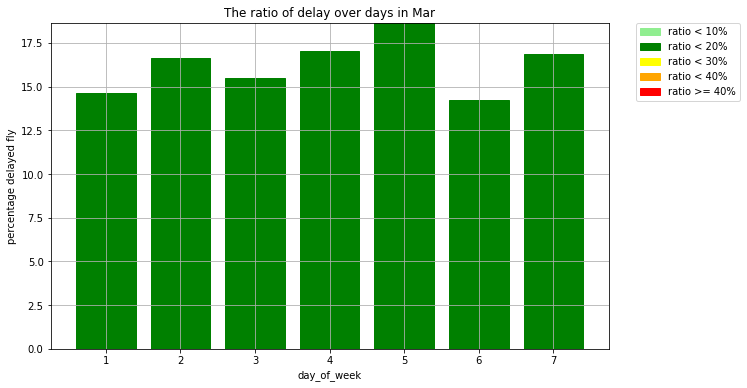

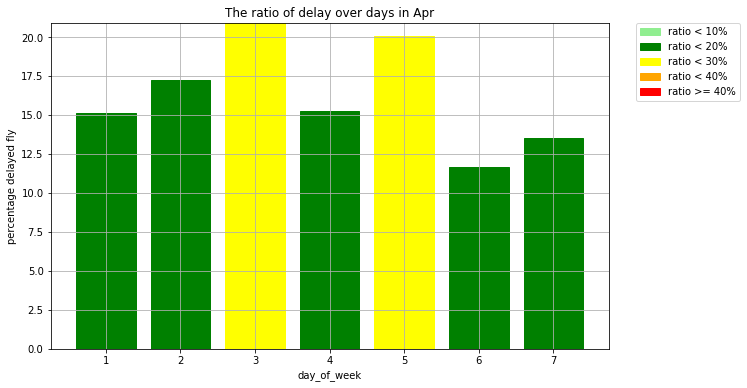

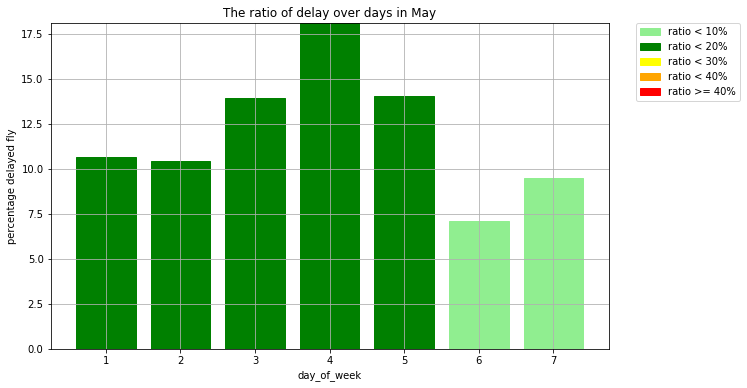

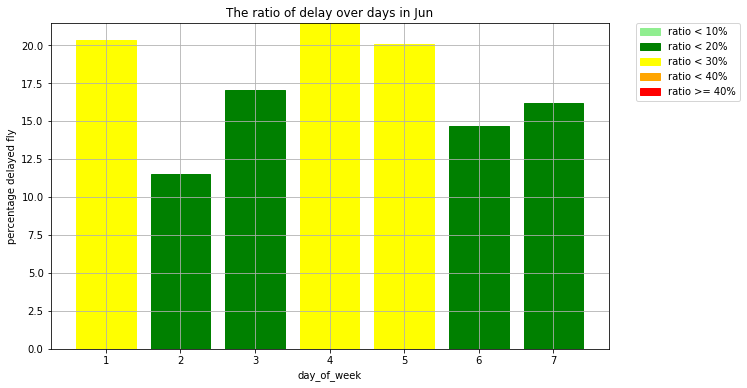

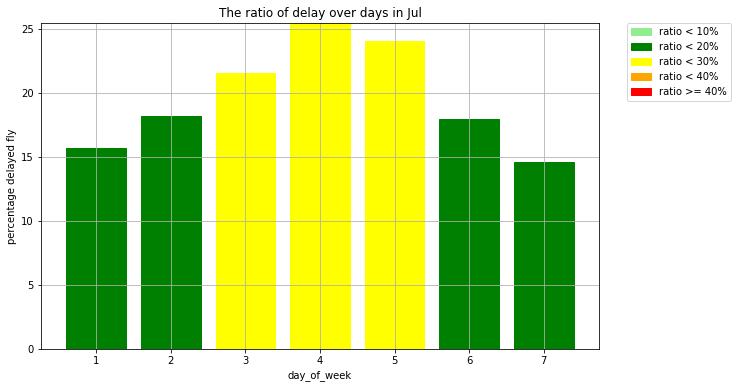

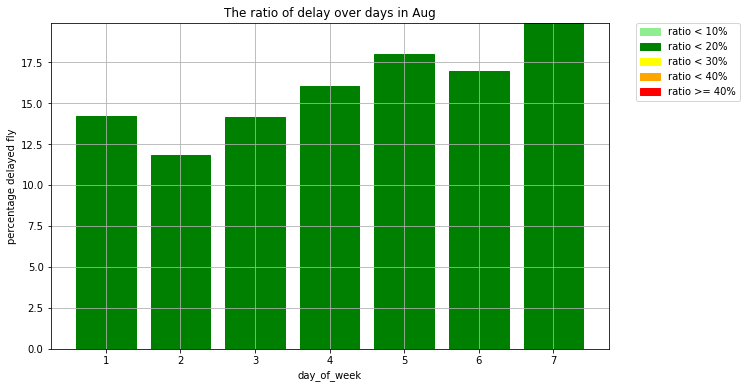

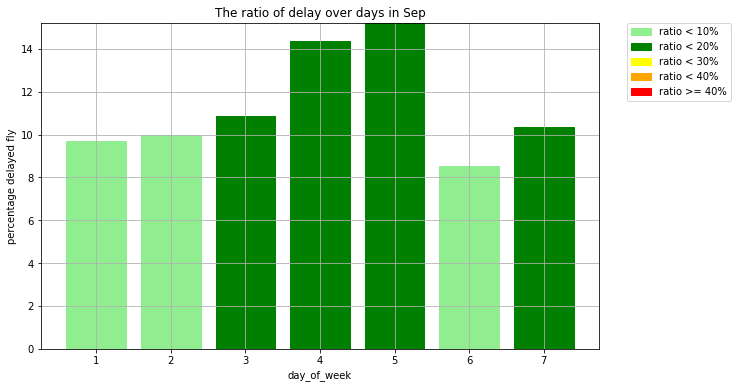

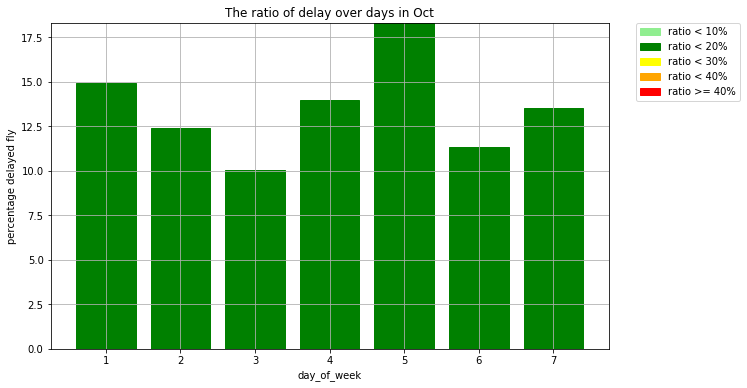

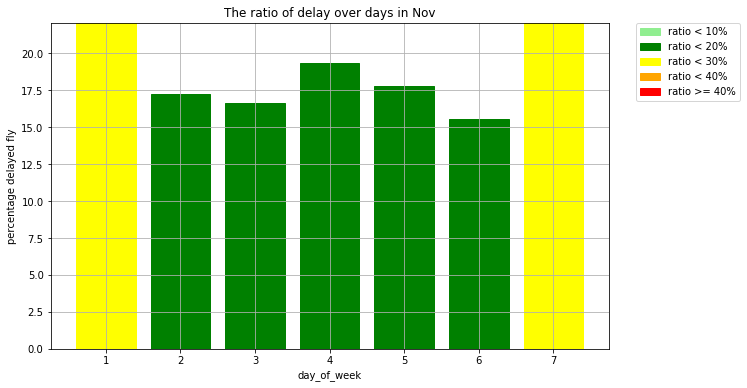

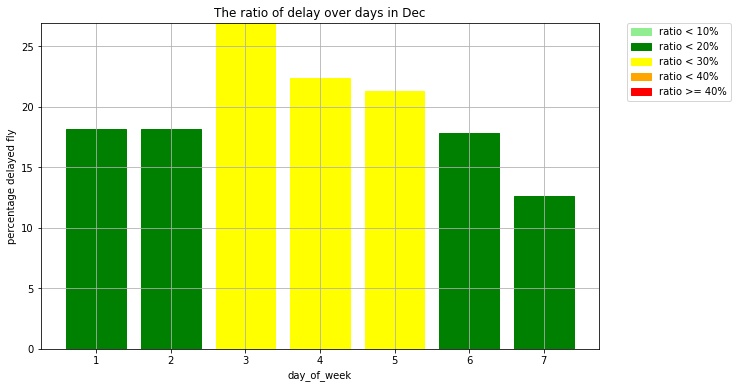

In [149]:
month= ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for i in range(1,13):
    pdf = pdf_month_week_percent[pdf_month_week_percent[0] == i][[1,2]]
    
    plot_day_over_month(pdf, month[i-1], 'day_of_week')

### Question 4.5
<div class="alert alert-info">
Plot a bar chart to show the percentage of delayed flights over months in a year. Discuss your findings from the figure.
</div>

In [151]:
percent_delay_per_month = (delayed_flight
                                 .groupby('year', 'month').sum('map_delay', 'tot')
                                 .withColumnRenamed('sum(map_delay)', 'sum_delay')
                                 .withColumnRenamed('sum(tot)', 'sum_tot')

                                 .selectExpr('year', 'month', 'double(sum_delay/sum_tot)*100 as percentage')

                                 .orderBy('year', 'month')
                            )

percent_delay_per_month.show()

+----+-----+------------------+
|year|month|        percentage|
+----+-----+------------------+
|1994|    1|25.622738580532058|
|1994|    2|22.490843484630616|
|1994|    3| 16.26949013617481|
|1994|    4|16.316729471814295|
|1994|    5| 11.89884381745262|
|1994|    6|17.485762148016875|
|1994|    7| 19.62402055439414|
|1994|    8|15.582413310005967|
|1994|    9|11.577859289540983|
|1994|   10|13.513804086350016|
|1994|   11|18.581741296577963|
|1994|   12|19.796565455563286|
+----+-----+------------------+



In [160]:
pdf = percent_delay_per_month.toPandas()[['month', 'percentage']]
pdf

,month,percentage
0,1,25.622739
1,2,22.490843
2,3,16.269490
3,4,16.316729
4,5,11.898844
5,6,17.485762
6,7,19.624021
7,8,15.582413
8,9,11.577859
9,10,13.513804


In [164]:
pdf.iloc[0, 1]

25.622738580532058

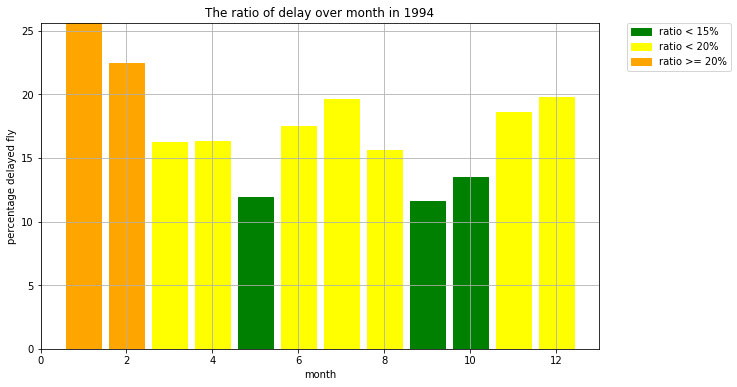

In [171]:
plt.figure(figsize=(10,6))
plt.xlabel('month')
plt.ylabel("percentage delayed fly")
plt.title(f'The ratio of delay over month in 1994')
plt.grid(True,which="both")

bars = plt.bar(pdf['month'], pdf['percentage'], align='center', edgecolor = "black")
for i in range(0, len(bars)):
    color = 'orange'
    if pdf.iloc[i, 1] < 15:
        color = 'green'
    elif pdf.iloc[i, 1] < 20:
        color = 'yellow'

    bars[i].set_color(color)


patch2 = mpatches.Patch(color='green', label='ratio < 15%')
patch3 = mpatches.Patch(color='yellow', label='ratio < 20%')
patch4 = mpatches.Patch(color='orange', label='ratio >= 20%')


plt.legend(handles=[patch2, patch3, patch4] , bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.margins(0.05, 0)

We are ready now to draw some observations from our data, even if we have only looked at data coming from a year worth of flights:

- The probability for a flight to be delayed is low at the beginning or at the very end of a given months
- Flights on two first weekdays and on the weekend, are less likely to be delayed
- May and September are very good months for travelling, as the probability of delay is low (remember we're working on US data. Do you think this is also true in France?)

Putting things together, we can have a global picture of the whole year!

In [173]:
from pyspark.sql.functions import  when

In [174]:
df_with_delay = df.withColumn('is_delay', when(df["arrival_delay"] >= 15, 1).otherwise(0))
statistic_day = df_with_delay.groupBy(['year','month', 'day_of_month', 'day_of_week'])\
    .agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio'))

# assume that we do statistic on year 1994
statistic_day = statistic_day\
    .orderBy('year', 'month', 'day_of_month', 'day_of_week')
pdf = pd.DataFrame(data=statistic_day.collect())

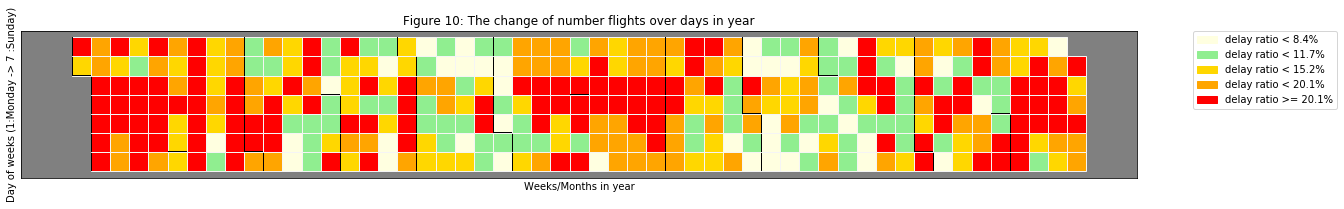

In [175]:
fig = plt.figure(figsize=(20,10))                                                             
ax = fig.add_subplot(1,1,1)     
plt.xlabel("Weeks/Months in year")
plt.ylabel("Day of weeks (1:Monday -> 7 :Sunday)")
plt.title('Figure 10: The change of number flights over days in year')
  
rec_size = 0.3
from matplotlib.patches import Rectangle
import datetime
num_days = len(pdf[0])
ax.patch.set_facecolor('gray')
ax.set_aspect('equal', 'box')
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())

for i in range(0, num_days):
    # extract information from the result
    year = pdf[0][i]
    month = pdf[1][i]
    day_of_month = pdf[2][i]
    day_of_week = pdf[3][i]
    day_of_year= datetime.date(year=year, month=month, day=day_of_month).timetuple()
    week_of_year = datetime.date(year=year, month=month, day=day_of_month).isocalendar()[1]
    
    # dealing with the week of the previous year
    if week_of_year == 52 and month == 1:
        week_of_year = 0
        
    # the coordinate of a day in graph
    X = week_of_year*rec_size
    Y = day_of_week*rec_size
    
    # use different colors to show the delay ratio
    color = 'white'
    if pdf[4][i] <= 0.084:
        color = 'lightyellow'
    elif pdf[4][i] <= 0.117:
        color = 'lightgreen'
    elif pdf[4][i] <= 0.152:
        color = 'gold'
    elif pdf[4][i] <= 0.201:
        color = 'orange'
    else:
        color = 'red'
    rect = plt.Rectangle((X - rec_size/2.0, Y - rec_size/2.0), rec_size, rec_size,
                      alpha=1, facecolor=color, edgecolor='whitesmoke')

    ax.add_patch(rect)
    
    # drawing boders to separate months
    if day_of_month <= 7:
        rect2 = plt.Rectangle((X -rec_size/2.0, Y - rec_size/2.0), 0.01, rec_size,
                      alpha=1, facecolor='black')
        ax.add_patch(rect2)
    if day_of_month == 1:
        rect2 = plt.Rectangle((X - rec_size/2.0, Y - rec_size/2.0), rec_size, 0.01,
                      alpha=1, facecolor='black')
        ax.add_patch(rect2)
ax.autoscale_view()

patch1 = mpatches.Patch(color='lightyellow', label='delay ratio < 8.4%')
patch2 = mpatches.Patch(color='lightgreen', label='delay ratio < 11.7%')
patch3 = mpatches.Patch(color='gold', label='delay ratio < 15.2%')
patch4 = mpatches.Patch(color='orange', label='delay ratio < 20.1%')
patch5 = mpatches.Patch(color='red', label='delay ratio >= 20.1%')

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

### Question 4.6
<div class="alert alert-info">

What is the delay probability for the top 20 busiest airports?  


By drawing the flight volume of each airport and the associated delay probability in a single plot, we can observe the relationship between airports, number of flights and the delay.  

<div class="label label-success">HINT </div>  Function `<df_colum>.isin(<list>)` helps checking whether a value in column belongs to a list.
<ul></ul>
<div class="label label-success">SUGGESTION </div>  You can try with different chart type to have a better visualization.
</div>

In [183]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- scheduled_arrival_time: integer (nullable = true)
 |-- arrival_delay: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- src_airport: string (nullable = true)
 |-- dest_airport: string (nullable = true)
 |-- carrier: string (nullable = true)



In [210]:
pdf_busiest_airport.head()

,airport,SUM
0,ORD,561461.0
1,DFW,516523.0
2,ATL,443074.0
3,LAX,306453.0
4,STL,304409.0


In [209]:
(df
     .filter(df['dest_airport'].isin(pdf_busiest_airport.airport.tolist()))
     .withColumn('is_delay', when(df["arrival_delay"] >= 15, 1).otherwise(0))
     .groupby('dest_airport').agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio'))
         
).show()

+------------+-------------------+
|dest_airport|        delay_ratio|
+------------+-------------------+
|         DCA| 0.1625185354169043|
|         IAH| 0.1682038904692124|
|         LGA|0.18058483911013024|
|         BOS| 0.2312067733134671|
|         EWR|0.25801250607815873|
|         LAS|0.17200994228419766|
|         DEN| 0.1866772149702635|
|         SEA|0.19755592707586975|
|         CLT| 0.1525694247281712|
|         PHX|0.16181133360287703|
|         STL|0.15047120418848167|
|         DFW| 0.1805386379966878|
|         SFO| 0.2030704934112329|
|         ATL| 0.2054894669386429|
|         ORD| 0.1436874383194699|
|         PIT|  0.170162622573165|
|         DTW|0.12610176784881844|
|         LAX|0.20074660529945934|
|         MSP|0.12432068484586159|
|         MCO| 0.1897780678851175|
+------------+-------------------+
only showing top 20 rows



In [ ]:
df_with_delay = df.withColumn('is_delay', when(df["arrival_delay"] >= 15, 1).otherwise(0))

statistic_day = df_with_delay.groupBy(['year','month', 'day_of_month', 'day_of_week'])\
    .agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio'))

### Question 4.7

<div class="alert alert-info">
What is the percentage of delayed flights which belong to one of the top 20 busiest carriers?  
Comment the figure!

<ul></ul>
<div class="label label-success">SUGGESTION </div>  You can try with different chart type to have a better visualization.
</div>

## Addition (bonus) questions

### Additional data
In the HDFS file system you have used for running the Notebook, you will notice that there are several other years available (in addition to 1994).

There are some other datasets that related to this use case:

- Airport IATA Codes to City names and Coordinates mapping: http://stat-computing.org/dataexpo/2009/airports.csv
- Carrier codes to Full name mapping: http://stat-computing.org/dataexpo/2009/carriers.csv
- Information about individual planes: http://stat-computing.org/dataexpo/2009/plane-data.csv
- Weather information: http://www.wunderground.com/weather/api/. You can subscribe for free to the developers' API and obtain (at a limited rate) historical weather information in many different formats. Also, to get an idea of the kind of information is available, you can use this link: http://www.wunderground.com/history/

### Question 5.1

<div class="alert alert-info">

Which airports are present in the dataset only as destination airport?

Which airport is present only as source airport in the dataset? 

</div>

### Question 5.2

<div class="alert alert-info">

Which airports have biggest delay probability ?

Which cities have largest delay duration in average ?

</div>

### Question 5.3

<div class="alert alert-info">

Is there any relationship between weather condition and the delay of flights in 1994 ?

</div>
